# Business understanding


# Data Preparation

1. Combine all feather file from source folder
2. Compose a df with tool indicators(SAS, Python, SQL, R, Excel)  
3. Compose a tool usage percentage table base on tool indicators
4. Use barplot to show the result


**Show a sample source file size**

In [1]:
import numpy as np
import pandas as pd
import math
from datetime import datetime, timedelta
import pickle
import re

sample = pd.read_feather("/Users/huilingchen/Documents/GitHub/indeed_web_scraper/source/11_12_2020")
sample.shape

(171, 7)

**Combine all feather file from source folder**

In [2]:
import os
import glob

dir_name = "/Users/huilingchen/Documents/GitHub/indeed_web_scraper/source"
os.chdir(dir_name)

all_filenames = [i for i in glob.glob('*')]
combined_source = pd.concat([pd.read_feather(f) for f in all_filenames], ignore_index=True)
combined_source


,Title,Company,Location,Link,Salary,Date,Description
0,Identity and Access Management Support Analyst...,Solu Technology Partners,None,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,None,10/28/2020,Title: Identity and Access Management Support ...
1,Lawson/Infor Systems Analyst,Arch Staffing & Consulting,None,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,"$80,000 - $90,000 a year",10/28/2020,Location: Spokane WA (remote during COVID)\nSa...
2,Forecast Analyst,Nexeo Plastics,"Dublin, OH 43016",https://www.indeed.com/rc/clk?jk=af3b81fe16665...,None,10/28/2020,"Date: Oct 28, 2020\nLocation: Dublin, OH, US, ..."
3,Production Support Analyst,Accenture,"Columbus, OH",https://www.indeed.com/rc/clk?jk=a19089fc3d9a2...,None,10/28/2020,Accenture Flex offers you the flexibility of l...
4,Corrections Data Analyst II,"JPMorgan Chase Bank, N.A.","Columbus, OH",https://www.indeed.com/rc/clk?jk=03a530d9989ff...,None,10/28/2020,Position Overview\nCCB Remediation and Correct...
...,...,...,...,...,...,...,...
1096,Clinical Applications Analyst,Ohio State University Medical Center,"Columbus, OH 43210 (The Ohio State University ...",https://www.indeed.com/rc/clk?jk=239e08a74bd92...,None,11/09/2020,Job Description\n\n\n\nPrevious Job\nNext Job\...
1097,Software Customer Support Analyst,"Cott Systems, Inc.","Columbus, OH 43231 (Northern Woods area)","https://www.indeed.com/company/Cott-Systems,-I...",None,11/09/2020,Customer Support Analyst\nCott Systems provide...
1098,Sr. Financial Analyst,Ohio State University Medical Center,"Columbus, OH 43210 (The Ohio State University ...",https://www.indeed.com/rc/clk?jk=b0f1e10fed01b...,None,11/09/2020,Job Description\n\n\n\nPrevious Job\nNext Job\...
1099,Associate Applications Analyst,Mast Global,"Columbus, OH",https://www.indeed.com/rc/clk?jk=18dcbc685eace...,None,11/09/2020,Description\n\nOVERVIEW:\n\nThe Applications A...


**Specify tool usage indicator**

In [7]:
df_indicator = pd.DataFrame()
df_indicator['SAS'] = np.where(combined_source['Description'].str.contains('SAS'), 'True','False')
df_indicator['python'] = np.where(combined_source['Description'].str.contains('python', flags=re.IGNORECASE),'True','False')
df_indicator['SQL'] = np.where(combined_source['Description'].str.contains('sql', flags=re.IGNORECASE),'True','False')
df_indicator['R'] = np.where(combined_source['Description'].str.contains(' R | R,', flags=re.IGNORECASE),'True','False')
df_indicator['excel'] = np.where(combined_source['Description'].str.contains('excel', flags=re.IGNORECASE),'True','False')
df_indicator

,SAS,python,SQL,R,excel
0,False,False,False,False,False
1,False,False,False,False,True
2,False,False,False,False,False
3,False,False,True,False,False
4,True,True,True,True,True
...,...,...,...,...,...
1096,False,False,False,False,False
1097,False,False,False,False,True
1098,False,False,True,False,False
1099,False,False,False,False,True


**Compose tool usage percentage chart**

In [8]:
percentage = pd.DataFrame()
percentage['SAS'] = df_indicator['SAS'].value_counts(normalize=True) * 100 
percentage['Python'] = df_indicator['python'].value_counts(normalize=True) * 100 
percentage['Excel'] = df_indicator['excel'].value_counts(normalize=True) * 100 
percentage['R'] = df_indicator['R'].value_counts(normalize=True) * 100 
percentage['SQL'] = df_indicator['SQL'].value_counts(normalize=True) * 100 
os.chdir("/Users/huilingchen/Documents/GitHub/indeed_web_scraper")
percentage

,SAS,Python,Excel,R,SQL
False,95.82198,92.552225,39.237057,96.911898,77.565849
True,4.17802,7.447775,60.762943,3.088102,22.434151


In [5]:
transposed=percentage.T
new_percentage=transposed.reset_index()
new_percentage

,index,False,True
0,SAS,95.821980,4.178020
1,Python,92.552225,7.447775
2,Excel,39.237057,60.762943
3,R,96.911898,3.088102
4,SQL,77.565849,22.434151


**Use barplot to show the result of tool usage**

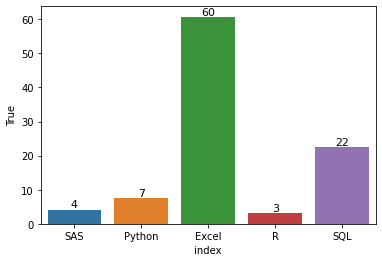

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
 
sns.barplot(x = 'index', y = 'True', data = new_percentage)

ax =plt.gca()
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_height(), '%d' % int(p.get_height()), fontsize=11, color='black', ha='center', va='bottom')
